## SVM with RBF kernel for Amazon fine food reviews for Bag of words,tf-idf, average word2vec, tf-idf weighted word2vec

### The objective

Given a text review, we have to predict whether the review represents positove sentiment or negative.
In other words, we ahve to classify the review as 'Positive' or 'Negative'.
We will use the Amazon fine food review dataset from Kaggle.com

https://www.kaggle.com/snap/amazon-fine-food-reviews
    
### Context

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Contents

    Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
    database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews    

We will use svm.SVC() for SVM classification with RBF kernel.sv.SVC() by default gives a RBF kernel SVM classifier. 
We will use AUC as the performance metric. Since SGDClassifier does not provide probability estimates, 
we need to use the decision_function for calculating AUC. 
Sklearn.metrics.roc_auc_score does not need probability estimates for computing AUC. 
It is possible to calculate the AUC score using the decision scores returned by svm.SVC(). 
Also see:- https://stackoverflow.com/questions/34621082/sklearn-auc-score-for-linearsvc-and-onesvm

The Scikit learn documentation for roc_auc_score reads:- 
    Target scores can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers). For binary y_true, y_score is supposed to be the score of the class with greater label.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html


First, import all required libraries


In [1]:
%%time
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn import svm
import parfit.parfit as pf
import sqlite3
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')
import gensim
print('Done')

Done
Wall time: 55.2 s


In [2]:

import pickle
def load_from_file(file_name):
    
    with open(file_name, 'rb') as filehandle:  
        # read the data as binary data stream
        list1 = pickle.load(filehandle)
        return list1
    
def dump_to_file(data,file_name):
    with open(file_name, 'wb') as filehandle:  
        # store the data as binary data stream
        pickle.dump(data, filehandle)


#### Function to print confusion matrix and classification report

In [3]:
from prettytable import PrettyTable
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,6), fontsize=10):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
def print_classif_report(input_dict):
    tab = PrettyTable()
    tab.field_names = ["Label","Precision","Recall","f1-Score","Support"]
    list1=[]
    for k,v in input_dict.items():
        list1=[]
        list1.append(k)
        for i,j in v.items():
            list1.append("{0:.2f}".format(j))
        
        tab.add_row(list1)
    print(tab)    

#### function to get important features for given classifier and vectorizer

In [4]:

def most_informative_feature(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names),reverse=True)[:n]

    print('Negative class')
    
    
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print(' ************************************* ')
    print('Positive class')
    
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)


### function to return column of text lengths

In [5]:
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [6]:
def plot_roc_curve(actual,pred):
    fpr,tpr,threholds = roc_curve(actual,pred)
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC : {}'.format(auc(fpr,tpr)))
    plt.show()

### Read the data from SQLite file

Read the data from database.
We will not consider 3 star reviews as they are neutral (neither completely positive nor negative)

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 as they are neutral

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

Check sample data

In [7]:
filtered_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


Sort the data by productid

In [7]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Remove duplicates

In [8]:
#Remove duplicate reviews by same user at same time
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Remove rows where helpfulness denominator is greater than helpfulness numerator

In [9]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

Function to clean the sentences.
The function will remove html tags and punctuation marks from the input text and return cleaned text.

In [49]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/|-|+|;|&]',r' ',cleantext)
    return  cleantext


Sort by time for time based splitting

In [11]:
sample=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Cleaning the review text by using above written function.
Also performing the stemming procedure to reduce the words to their base stem forms.
Cleaned text will be stored in separate column.
For tf-idf weighted word2vec, we are storing non-stemmed clean review text in another column.

In [12]:
i=0
str1=' '
str2=' '
final_string=[]
final_string_2=[]
s=''
s1=''
for sent in sample['Text'].values:
    filtered_sentence=[]
    filtered_nostem = []
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    s1 = (w.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    filtered_nostem.append(s1)
                    
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    str2 = b" ".join(filtered_nostem) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    final_string_2.append(str2)
    i+=1

In [13]:
#adding a column  which displays the data after pre-processing of the review 
sample['CleanedText']=final_string
sample['CleanedTextNoStem']=final_string_2

Save the cleaned text in a file for use later

In [ ]:
#pickle.dump(sample,open('cleaned_final.p','wb'))
pd.to_pickle(sample,'cleaned_Text.pkl')

In [7]:
loaddf=pd.read_pickle('cleaned_Text.pkl')

In [8]:
sample=loaddf

In [9]:
#sample.head(1)
sample.head(1)
#sample['Score'].value_counts()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedTextNoStem
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...


### First using Bag of Words vectorizer

Sort by timestamp and take 40K samples for RBF kernel classification as it is not efficient for large datasets.

In [10]:
#sort by time for time based splitting and take 40K samples
sample=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sample = sample[:40000]
sample.shape

(40000, 12)

In [11]:
# Split into train,validation and test sets
from sklearn.model_selection import train_test_split

X_tr, x_test, Y_tr, y_test = train_test_split(sample['CleanedText'].values,sample['Score'].values,test_size=0.25,shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(X_tr,Y_tr,test_size=0.3,shuffle=False)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(21000,)
(9000,)
(10000,)


New class To prevent WRITEBACKIFCOPY error 
Source:-
    https://github.com/scikit-learn/scikit-learn/issues/6614

In [20]:
class MyCountVectorizer(CountVectorizer):
    def fit_transform(self,x):
        res = super(MyCountVectorizer,self).fit_transform(x)
        res.sort_indices()
        return res

In [21]:
count_vect = MyCountVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_val =  count_vect.transform(x_val)
bag_of_words_test =  count_vect.transform(x_test)

import scipy.sparse
scipy.sparse.save_npz('bag_of_words_train_rbf', bag_of_words_train)
scipy.sparse.save_npz('bag_of_words_val_rbf', bag_of_words_val)
scipy.sparse.save_npz('bag_of_words_test_rbf', bag_of_words_test)

In [22]:
bag_of_words_val=scipy.sparse.load_npz('bag_of_words_val_rbf.npz')
bag_of_words_test=scipy.sparse.load_npz('bag_of_words_test_rbf.npz')
bag_of_words_train=scipy.sparse.load_npz('bag_of_words_train_rbf.npz')

Scale and perform optimal hyperparameter search using parfit library 
More info about parfit is available at :-
https://github.com/jmcarpenter2/parfit/blob/master/docs/documentation.md

In [23]:
scaler = StandardScaler(with_mean=False)
bag_of_words_val=scaler.fit_transform(bag_of_words_val)
bag_of_words_train=scaler.fit_transform(bag_of_words_train)
bag_of_words_test=scaler.fit_transform(bag_of_words_test)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 19.0min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 25.9min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 32.5min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 38.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.7min finished


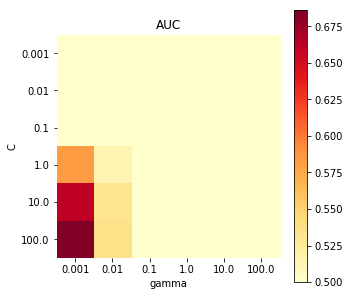

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.6859492187148745
Wall time: 42min 57s


In [24]:
%%time

C_range = 10. ** np.arange(-3, 3)
gamma_range = 10. ** np.arange(-3, 3)

grid = dict(gamma=gamma_range, C=C_range)

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(svm.SVC(),paramGrid,bag_of_words_train,y_train,bag_of_words_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModel,bestScore)

Evaluate best model on test set

AUC score: 0.86
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.61   |  0.39  |   0.48   | 1166.00  |
|      1       |    0.92   |  0.97  |   0.94   | 8834.00  |
|  micro avg   |    0.90   |  0.90  |   0.90   | 10000.00 |
|  macro avg   |    0.76   |  0.68  |   0.71   | 10000.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 10000.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


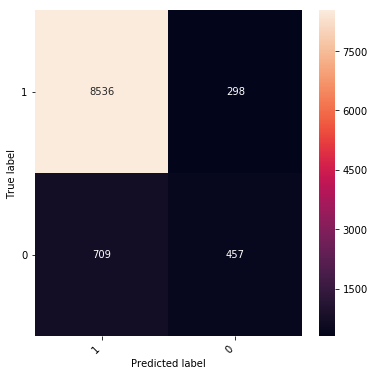

In [25]:

predicted = bestModel.predict(bag_of_words_test)
bow_score = roc_auc_score(y_test,bestModel.decision_function(bag_of_words_test))
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



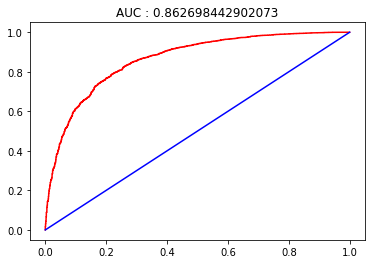

In [26]:
plot_roc_curve(y_test,bestModel.decision_function(bag_of_words_test))

### RBF kerner SVM for tf-idf

New class To prevent WRITEBACKIFCOPY error 
Source:-
    https://github.com/scikit-learn/scikit-learn/issues/6614

In [68]:

class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self,x):
        res = super(MyTfidfVectorizer,self).fit_transform(x)
        res.sort_indices()
        return res
    def transform(self,x):
        result = super(MyTfidfVectorizer,self).transform(x)
        result.sort_indices()
        return result

In [40]:
tfidf_vect = MyTfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
tfidf_train = tfidf_vect.fit_transform(x_train)
tfidf_val =  tfidf_vect.transform(x_val)
tfidf_test =  tfidf_vect.transform(x_test)

import scipy.sparse
scipy.sparse.save_npz('tfidf_train_rbf', tfidf_train)
scipy.sparse.save_npz('tfidf_val_rbf', tfidf_val)
scipy.sparse.save_npz('tfidf_test_rbf', tfidf_test)

In [41]:
tfidf_train=scipy.sparse.load_npz('tfidf_train_rbf.npz')
tfidf_val=scipy.sparse.load_npz('tfidf_val_rbf.npz')
tfidf_test=scipy.sparse.load_npz('tfidf_test_rbf.npz')

Scale and perform optimal hyperparameter search using parfit library 
More info about parfit is available at :-
https://github.com/jmcarpenter2/parfit/blob/master/docs/documentation.md

In [42]:
scaler = StandardScaler(with_mean=False)
tfidf_val=scaler.fit_transform(tfidf_val)
tfidf_train=scaler.fit_transform(tfidf_train)
tfidf_test=scaler.fit_transform(tfidf_test)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done  39 out of  49 | elapsed: 42.2min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed: 51.4min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed: 60.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed: 60.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:  7.0min finished


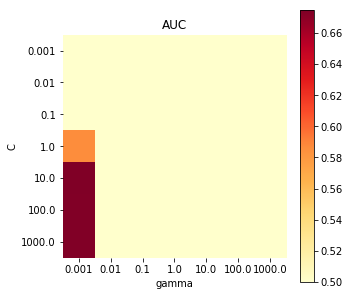

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.6744247275512434
Wall time: 1h 7min 34s


In [45]:
%%time

C_range = 10. ** np.arange(-3, 4)
gamma_range = 10. ** np.arange(-3, 4)

grid = dict(gamma=gamma_range, C=C_range)

paramGrid = ParameterGrid(grid)

bestModelIdf, bestScore, allModels, allScores = pf.bestFit(svm.SVC(),paramGrid,tfidf_train,y_train,tfidf_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModelIdf,bestScore)

Evaluate best model on test set

AUC score: 0.89
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.70   |  0.37  |   0.49   | 1166.00  |
|      1       |    0.92   |  0.98  |   0.95   | 8834.00  |
|  micro avg   |    0.91   |  0.91  |   0.91   | 10000.00 |
|  macro avg   |    0.81   |  0.68  |   0.72   | 10000.00 |
| weighted avg |    0.90   |  0.91  |   0.90   | 10000.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


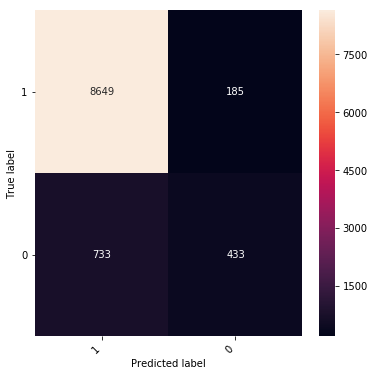

In [46]:

predicted = bestModelIdf.predict(tfidf_test)
tfidf_score = roc_auc_score(y_test,bestModelIdf.decision_function(tfidf_test))
print('AUC score:',round(tfidf_score,2))
print('Classification report  :-')
tfidf_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(tfidf_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



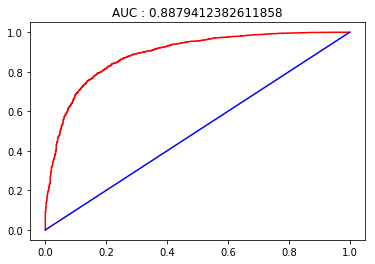

In [47]:
plot_roc_curve(y_test,bestModelIdf.decision_function(tfidf_test))

### RBF kernel SVM for average word2Vec

In [50]:

from nltk.tokenize import word_tokenize

train_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[:21000]]]
val_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[21000:30000]]]
test_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[30000:]]]


In [51]:
dump_to_file(train_list,'train_list_rbf.data')
dump_to_file(val_list,'val_list_rbf.data')
dump_to_file(test_list,'test_list_rbf.data')

In [39]:
train_list = load_from_file('train_list_rbf.data')
val_list = load_from_file('val_list_rbf.data')
test_list = load_from_file('test_list_rbf.data')

Build vocabulary using gensim

In [40]:
w2v_model = gensim.models.Word2Vec(train_list,min_count=10,size=50)

In [41]:
print(w2v_model.most_similar('good'))
print('******************************************************************************')
print(w2v_model.most_similar('bad'))

[('great', 0.7843326926231384), ('amazing', 0.7536581754684448), ('awesome', 0.7263890504837036), ('exactly', 0.7219219207763672), ('fantastic', 0.714063286781311), ('bad', 0.7128772139549255), ('real', 0.705359935760498), ('awful', 0.7004193067550659), ('terrible', 0.6950428485870361), ('pretty', 0.6702072024345398)]
******************************************************************************
[('that', 0.8145260810852051), ('exactly', 0.7825716733932495), ('awful', 0.7721084356307983), ('expect', 0.7654287219047546), ('guess', 0.7629654407501221), ('terrible', 0.7443379163742065), ('thats', 0.7392899990081787), ('actually', 0.7354344725608826), ('mean', 0.7350152730941772), ('horrible', 0.7346218824386597)]


vectorize train data set

In [42]:
avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    avg_wt_vecs.append(sent_vec) #append to list of sentence vectors 

In [28]:
print(np.isfinite(avg_wt_vecs).all())
print(np.isnan(avg_wt_vecs).any())

True
False


Vectorize validation set

In [43]:
val_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list

for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if (cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    val_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

In [30]:
print(np.isfinite(val_avg_wt_vecs).all())
print(np.isnan(val_avg_wt_vecs).any())

True
False


Vectorize test set

In [44]:
test_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    test_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

In [32]:
print(np.isfinite(test_avg_wt_vecs).all())
print(np.isnan(test_avg_wt_vecs).any())

True
False


In [45]:
X_tr = avg_wt_vecs
X_test = test_avg_wt_vecs
X_val = val_avg_wt_vecs
print(len(X_tr))
print(len(X_val))
print(len(X_test))

dump_to_file(avg_wt_vecs,'avg_wt_vecs_train_rbf.data')
dump_to_file(val_avg_wt_vecs,'val_avg_wt_vecs_rbf.data')
dump_to_file(test_avg_wt_vecs,'test_avg_wt_vecs_rbf.data')


21000
9000
10000


In [46]:
avg_wt_vecs=load_from_file('avg_wt_vecs_train_rbf.data')
val_avg_wt_vecs=load_from_file('val_avg_wt_vecs_rbf.data')
test_avg_wt_vecs=load_from_file('test_avg_wt_vecs_rbf.data')

Scale and perform optimal hyperparameter search using parfit library 
More info about parfit is available at :-
https://github.com/jmcarpenter2/parfit/blob/master/docs/documentation.md

In [47]:
scaler=StandardScaler()
X_tr=scaler.fit_transform(avg_wt_vecs)
X_val=scaler.fit_transform(val_avg_wt_vecs)
X_test=scaler.fit_transform(test_avg_wt_vecs)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  56 out of  64 | elapsed: 17.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 23.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.6min finished


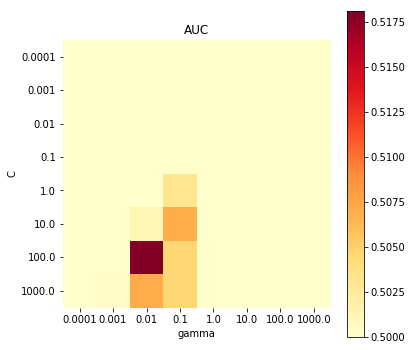

SVC(C=100.0, cache_size=200, class_weight={1: 0.2, 0: 0.8}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5181146841091717
Wall time: 25min 40s


In [63]:
%%time

grid = {'C':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
        'gamma':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
       }

paramGrid = ParameterGrid(grid)

bestModelAvgW2v, bestScore, allModels, allScores = pf.bestFit(svm.SVC(class_weight={1:0.2,0:0.8}),paramGrid,X_tr,y_train,X_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModelAvgW2v,bestScore)

Evaluate model on test set

AUC score: 0.54
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.16   |  0.11  |   0.13   | 1165.00  |
|      1       |    0.89   |  0.93  |   0.91   | 8835.00  |
|  micro avg   |    0.83   |  0.83  |   0.83   | 10000.00 |
|  macro avg   |    0.52   |  0.52  |   0.52   | 10000.00 |
| weighted avg |    0.80   |  0.83  |   0.82   | 10000.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


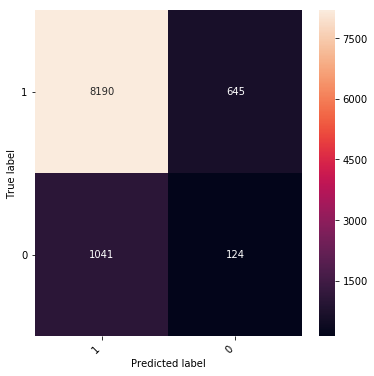

In [64]:

predicted = bestModelAvgW2v.predict(X_test)
avg_w2v_score = roc_auc_score(y_test,bestModelAvgW2v.decision_function(X_test))
print('AUC score:',round(avg_w2v_score,2))
print('Classification report  :-')
avg_w2v_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(avg_w2v_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



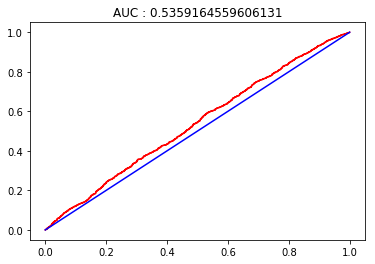

In [65]:
plot_roc_curve(y_test,bestModelAvgW2v.decision_function(X_test))

### RBF kernel SVM using TF-IDF weighted word2vec

In [66]:
X_tr1, X_test, y_tr1, y_test = train_test_split(sample['CleanedTextNoStem'].values, sample['Score'].values, test_size=0.25,shuffle=False)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr1, y_tr1, test_size=0.3,shuffle=False)
print(X_tr.shape)
print(X_val.shape)
print(X_test.shape)

(21000,)
(9000,)
(10000,)


In [69]:
tfidf_vect = MyTfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
tfidf_train = tfidf_vect.fit_transform(X_tr)

tfidf_test =  tfidf_vect.transform(X_test) #use same vectorizer to transform test instances
tfidf_val =  tfidf_vect.transform(X_val) #use same vectorizer to transform test instances

features = tfidf_vect.get_feature_names()
#len(features)
dict_feature={}
idx=0
for feature in features:
    dict_feature[feature]=idx
    idx += 1
#len(features)

vectorize the train set

In [70]:
index = 0
tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in train_list: # for each review/sentence
    
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if sum_tfidf != 0:
            sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    
       
    tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    
    index += 1
    

In [71]:
print(np.isfinite(tfidf_wt_vecs).all())
print(np.isnan(tfidf_wt_vecs).any())

True
False


Vectorize validation set

In [72]:
index = 0
val_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_val[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    val_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [33]:
print(np.isfinite(val_tfidf_wt_vecs).all())
print(np.isnan(val_tfidf_wt_vecs).any())

True
False


Vectorize test set

In [73]:
index = 0
test_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    test_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [35]:
print(np.isfinite(test_tfidf_wt_vecs).all())
print(np.isnan(test_tfidf_wt_vecs).any())

True
False


In [74]:
X_tr = tfidf_wt_vecs
X_test = test_tfidf_wt_vecs
X_val = val_tfidf_wt_vecs

In [75]:
dump_to_file(test_tfidf_wt_vecs,'test_tfidf_wt_vecs_rbf.data')
dump_to_file(tfidf_wt_vecs,'tfidf_wt_vecs_rbf.data')
dump_to_file(val_tfidf_wt_vecs,'val_tfidf_wt_vecs_rbf.data')
tfidf_wt_vecs = load_from_file('tfidf_wt_vecs_rbf.data')
val_tfidf_wt_vecs = load_from_file('val_tfidf_wt_vecs_rbf.data')
test_tfidf_wt_vecs = load_from_file('test_tfidf_wt_vecs_rbf.data')

Scale and perform optimal hyperparameter search using parfit library 
More info about parfit is available at :-
https://github.com/jmcarpenter2/parfit/blob/master/docs/documentation.md

In [76]:
scaler=StandardScaler()
X_tr=scaler.fit_transform(tfidf_wt_vecs)
X_val=scaler.fit_transform(val_tfidf_wt_vecs)
X_test=scaler.fit_transform(test_tfidf_wt_vecs)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  56 out of  64 | elapsed:  9.7min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 12.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.2min finished


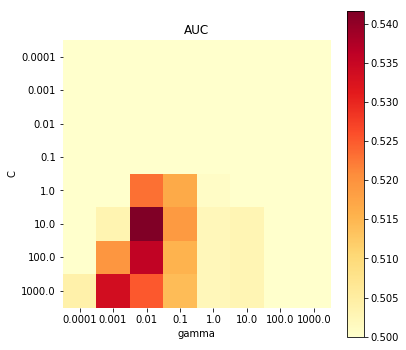

SVC(C=10.0, cache_size=200, class_weight={1: 0.2, 0: 0.8}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5416542963225432
Wall time: 14min 54s


In [77]:
%%time

grid = {'C':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3],
        'gamma':[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
       }

paramGrid = ParameterGrid(grid)

bestModeltfidfW2v, bestScore, allModels, allScores = pf.bestFit(svm.SVC(class_weight={1:0.2,0:0.8}),paramGrid,X_tr,y_train,X_val,y_val,metric=roc_auc_score,greater_is_better=True,scoreLabel='AUC')

print(bestModeltfidfW2v,bestScore)

Evaluate model on test set

AUC score: 0.61
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.24   |  0.15  |   0.18   | 1165.00  |
|      1       |    0.89   |  0.94  |   0.92   | 8835.00  |
|  micro avg   |    0.85   |  0.85  |   0.85   | 10000.00 |
|  macro avg   |    0.57   |  0.54  |   0.55   | 10000.00 |
| weighted avg |    0.82   |  0.85  |   0.83   | 10000.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


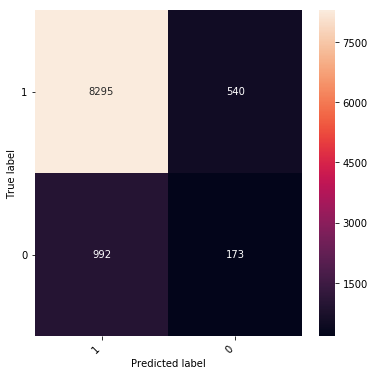

In [78]:

predicted = bestModeltfidfW2v.predict(X_test)
tfidf_w2v_score = roc_auc_score(y_test,bestModeltfidfW2v.decision_function(X_test))
print('AUC score:',round(tfidf_w2v_score,2))
print('Classification report  :-')
tfidf_w2v_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(tfidf_w2v_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])



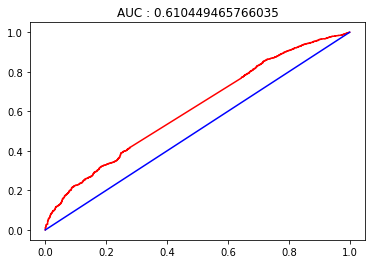

In [79]:
plot_roc_curve(y_test,bestModeltfidfW2v.decision_function(X_test))

In [1]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.field_names = ["Vectorizer","Gamma","Alpha","AUC"]
list1=["BOW bigram","0.001","100","0.86"]
list2=["TFIDF bigram","0.001","10","0.89"]
list3=["Avg w2v","0.01","100","0.54"]
list4=["TFIDF w2v","0.01","10","0.61"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+--------------+-------+-------+------+
|  Vectorizer  | Gamma | Alpha | AUC  |
+--------------+-------+-------+------+
|  BOW bigram  | 0.001 |  100  | 0.86 |
| TFIDF bigram | 0.001 |   10  | 0.89 |
|   Avg w2v    |  0.01 |  100  | 0.54 |
|  TFIDF w2v   |  0.01 |   10  | 0.61 |
+--------------+-------+-------+------+
